z矩阵:
[[0.58   0.54   0.4    ... 0.58   0.     0.    ]
 [0.93   0.83   0.77   ... 0.81   0.98   0.    ]
 [0.     0.     0.77   ... 0.92   0.     0.    ]
 ...
 [0.84   0.87   0.72   ... 0.88   0.9    0.74  ]
 [0.     0.     0.8    ... 0.85   0.     0.    ]
 [0.     0.     0.81   ... 0.     0.     0.4356]]


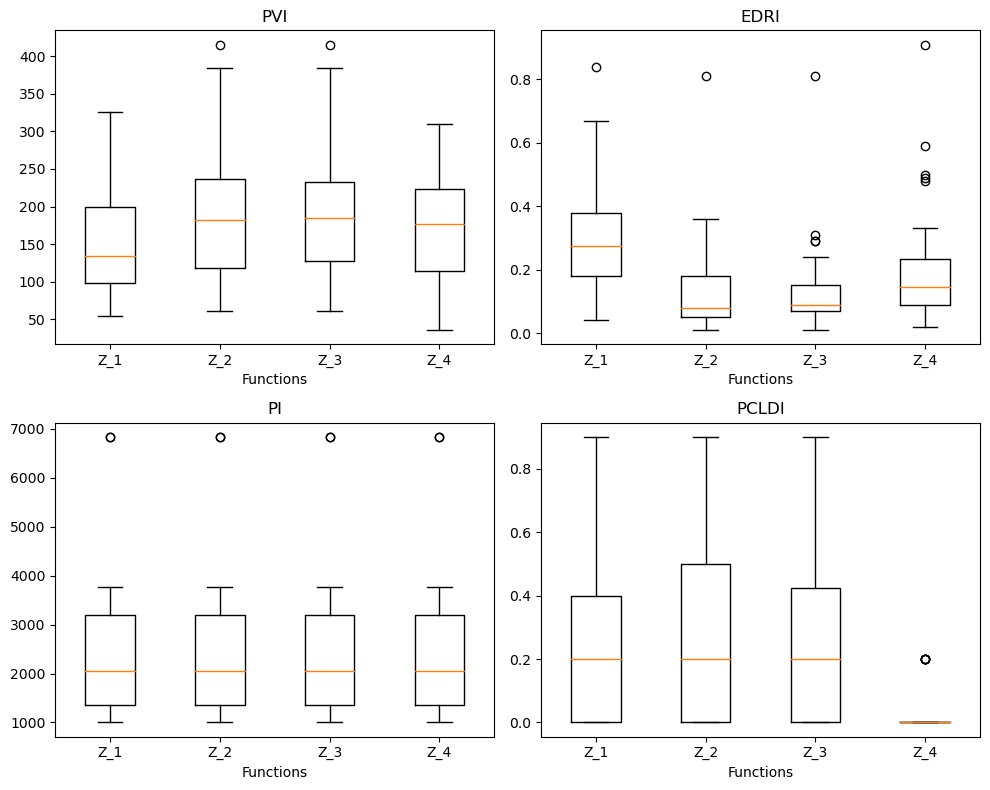

In [1]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import linprog
from scipy.optimize import linear_sum_assignment
from math import radians, sin, cos, sqrt, atan2
from pulp import *
import csv
import networkx as nx


# 读取货物和车辆的数据
cargo_df = pd.read_csv('cargo - s.csv')
vehicles_df = pd.read_csv('vehicles - d.csv')
type_matching_df = pd.read_csv('Type_matching.csv')


def haversine_distance(point1, point2):
    lat1, lon1 = point1
    lat2, lon2 = point2
    R = 6371  # 地球半径，单位km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2) ** 2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2) ** 2
    c0 = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c0
    return distance

# 定义模型参数
w1, w2, w3, w4 = 0.36, 0.11, 0.18, 0.35
n_vehicles = len(vehicles_df)
n_cargo = len(cargo_df)
cargo_types = cargo_df['type'].values
cargo_weights = cargo_df['w_j^c'].values
cargo_volumes = cargo_df['v_j^c'].values
cargo_origins = list(zip(cargo_df['lat_j^c1'].values, cargo_df['lon_j^c1'].values))
cargo_destinations = list(zip(cargo_df['lat_j^c2'].values, cargo_df['lon_j^c2'].values))
cargo_pickup_times = pd.to_datetime(cargo_df['t_j^c1'], format='%Y/%m/%d %H:%M').values
cargo_delivery_times = pd.to_datetime(cargo_df['t_j^c2'], format='%Y/%m/%d %H:%M').values
cargo_fees = cargo_df['f_j^c'].values
vehicle_types = vehicles_df['type'].values
vehicle_weights = vehicles_df['w_i^v'].values
vehicle_volumes = vehicles_df['v_i^v'].values
vehicle_latitudes = vehicles_df['lat_i^v'].values
vehicle_longitudes = vehicles_df['lon_i^v'].values
cargo_indexes = np.arange(n_cargo)
vehicle_indexes = np.arange(n_vehicles)

# 计算车辆和货物之间的匹配度a1
matched_pairs = set() # 创建一个空的集合
type_matching = type_matching_df.pivot(index='type_i^v', columns='type_j^c', values='num').fillna(0)
a1 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
        if (i,j) in matched_pairs:
            break # 如果该组匹配已经出现过，则直接跳出内层for循环
        else:
            matching_type = type_matching.loc[vehicles_df['type'][i].split('_')[0], cargo_df['type'][j]]
            matched_pairs.add((i,j)) # 将该组匹配加入已匹配组合的集合中
            a1[i, j] = matching_type
            if matching_type == 0:
                a1[i, j] = 0
                break  # 直接跳出内层for循环

# 计算车辆和货物之间的匹配度a2
a2 = np.zeros((n_vehicles, n_cargo))
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 检查重量和体积是否符合要求
            if cargo_weights[j] <= vehicle_weights[i] and cargo_volumes[j] <= vehicle_volumes[i]:
                a2[i, j] = round(max(1 - ((vehicle_weights[i] - cargo_weights[j]) / vehicle_weights[i]), 1 - ((vehicle_volumes[i] - cargo_volumes[j]) / vehicle_volumes[i])), 2)
                matched_pairs.add((i, j))
            else:
                a2[i, j] = 0

# 计算车辆和货物之间的匹配度a3、a4
a3 = np.zeros((n_vehicles, n_cargo))
a4 = np.zeros((n_vehicles,n_cargo))
z = np.zeros((n_vehicles, n_cargo))
e = np.zeros((n_vehicles,n_cargo))
p = np.zeros((n_vehicles,n_cargo))
c = np.zeros((n_vehicles,n_cargo))
dist1 = np.zeros((n_vehicles,n_cargo))
dist2 = np.zeros((n_vehicles,n_cargo))
time1 = np.zeros((n_vehicles,n_cargo))
time2 = np.zeros((n_vehicles,n_cargo))
total_time = np.zeros((n_vehicles,n_cargo))
delta = np.timedelta64(1, 's')
for i in range(n_vehicles):
    for j in range(n_cargo):
            # 计算距离和时间
            dist1[i, j] = haversine_distance((vehicle_latitudes[i], vehicle_longitudes[i]), cargo_origins[j])
            dist2[i, j] = haversine_distance(cargo_origins[j], cargo_destinations[j])
            time1[i, j] = dist1[i, j] / 40
            time2[i, j] = dist2[i, j] / 80
            total_time[i, j] = time1[i, j] + time2[i, j] + 3
            # 检查时间是否符合要求
         
            time_diff_seconds = (cargo_delivery_times[j] - cargo_pickup_times[j]) / delta
            if total_time[i, j] <= time_diff_seconds / 3600:
                a3[i, j] = round(total_time[i, j] / (time_diff_seconds / (3600 * 2)), 2)
                a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
                matched_pairs.add((i, j))
            else:
                a3[i, j] = 0
                break

b = 1.92
u = 0.5
c[i, j] = u * dist1[i, j] + b * (cargo_weights[j] / vehicle_weights[i]) * u * dist2[i, j]

# 循环检查每个匹配对
for i in range(n_vehicles):
    for j in range(n_cargo):
        # 检查个匹配度是否为零
        if np.any([a1[i, j] == 0, a2[i, j] == 0, a3[i, j] == 0]):
            e[i, j] = z[i, j] = p[i, j] = a4[i, j] = 0
        else:
            a4[i, j] = round(dist2[i, j] / (dist1[i, j] + dist2[i, j]), 2)
            z[i, j] = round((w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]), 2)
            e[i, j] = round((cargo_fees[j] - c[i, j]) / (total_time[i, j] + 3), 2)
            p[i, j] = round((cargo_fees[j] - c[i, j]), 2)

z[i, j] = w1 * a1[i, j] + w2 * a2[i, j] + w3 * a3[i, j] + w4 * a4[i, j]
# 输出z矩阵
print("z矩阵:")
print(z)


# 将z矩阵保存在z_matrix全局变量中
z_matrix = z
e_matrix = e
a4_matrix = a4
p_matrix = p
# 定义some_function函数
def some_function():
    global e_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = e_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVLC_z2_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global a4_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = a4_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVLC_z3_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

# 定义some_function函数
def some_function():
    global p_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = p_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVLC_z1_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean]) 

# 定义some_function函数
def some_function():
    global z_matrix
    # 在函数内部对z_matrix做一些处理或者调用其他函数
    # ...

# 在后续代码中调用some_function函数
some_function()


matching_matrix = z_matrix



# 使用Kuhn-Munkres算法求解车辆和货物匹配问题
row_ind, col_ind = linear_sum_assignment(-matching_matrix)
matching = np.column_stack((row_ind, col_ind))

# 输出车辆和货物匹配的结果到csv文件
e_sum = 0
k_sum = 0
p_sum = 0
d_sum = 0
count = 0

with open('MVLC_z4_matches.csv', mode='w', encoding='utf-8-sig', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Vehicle', 'Cargo', 'Match', 'PVI', 'EDRI', 'PI', 'PCLDI'])
    
    for vehicle, cargo in matching:
        writer.writerow([vehicle, cargo, 'Yes', e[vehicle][cargo], 1 - a4[vehicle][cargo], p[vehicle][cargo], 1 - a1[vehicle][cargo]])
        
        # 累加"E"和"K"的值
        e_sum += e[vehicle][cargo]
        k_sum += 1 - a4[vehicle][cargo]
        p_sum += p[vehicle][cargo]
        d_sum += 1 - a1[vehicle][cargo]
        count += 1
    
    # 计算"E"和"K"的平均值
    e_mean = e_sum / count
    k_mean = k_sum / count
    p_mean = p_sum / count
    d_mean = d_sum / count
    # 写入"E"和"K"的平均值到CSV文件的对应列的最下方
    writer.writerow(['Average', 'Average', '', e_mean, k_mean, p_mean, d_mean])  

import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
p_data = pd.read_csv('MVLC_z1_matches.csv')['PVI'].iloc[:-1].tolist()
e_data = pd.read_csv('MVLC_z2_matches.csv')['PVI'].iloc[:-1].tolist()
k_data = pd.read_csv('MVLC_z3_matches.csv')['PVI'].iloc[:-1].tolist()
z_data = pd.read_csv('MVLC_z4_matches.csv')['PVI'].iloc[:-1].tolist()

# 绘制箱线图
data = [p_data, e_data, k_data, z_data]
labels = ['Z_1', 'Z_2', 'Z_3', 'Z_4']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# 第一个子图
ax1 = axes[0, 0]
ax1.boxplot(data)
ax1.set_xticklabels(labels)
ax1.set_xlabel('Functions')
ax1.set_ylabel('')
ax1.set_title('PVI')

# 第二个子图
p_data = pd.read_csv('MVLC_z1_matches.csv')['EDRI'].iloc[:-1].tolist()
e_data = pd.read_csv('MVLC_z2_matches.csv')['EDRI'].iloc[:-1].tolist()
k_data = pd.read_csv('MVLC_z3_matches.csv')['EDRI'].iloc[:-1].tolist()
z_data = pd.read_csv('MVLC_z4_matches.csv')['EDRI'].iloc[:-1].tolist()
data = [p_data, e_data, k_data, z_data]
ax2 = axes[0, 1]
ax2.boxplot(data)
ax2.set_xticklabels(labels)
ax2.set_xlabel('Functions')
ax2.set_ylabel('')
ax2.set_title('EDRI')

# 第三个子图
p_data = pd.read_csv('MVLC_z1_matches.csv')['PI'].iloc[:-1].tolist()
e_data = pd.read_csv('MVLC_z2_matches.csv')['PI'].iloc[:-1].tolist()
k_data = pd.read_csv('MVLC_z3_matches.csv')['PI'].iloc[:-1].tolist()
z_data = pd.read_csv('MVLC_z4_matches.csv')['PI'].iloc[:-1].tolist()
data = [p_data, e_data, k_data, z_data]
ax3 = axes[1, 0]
ax3.boxplot(data)
ax3.set_xticklabels(labels)
ax3.set_xlabel('Functions')
ax3.set_ylabel('')
ax3.set_title('PI')

# 第四个子图
p_data = pd.read_csv('MVLC_z1_matches.csv')['PCLDI'].iloc[:-1].tolist()
e_data = pd.read_csv('MVLC_z2_matches.csv')['PCLDI'].iloc[:-1].tolist()
k_data = pd.read_csv('MVLC_z3_matches.csv')['PCLDI'].iloc[:-1].tolist()
z_data = pd.read_csv('MVLC_z4_matches.csv')['PCLDI'].iloc[:-1].tolist()
data = [p_data, e_data, k_data, z_data]
ax4 = axes[1, 1]
ax4.boxplot(data)
ax4.set_xticklabels(labels)
ax4.set_xlabel('Functions')
ax4.set_ylabel('')
ax4.set_title('PCLDI')

# 调整子图之间的间距
plt.tight_layout()

# 显示图形
plt.show()